##### Copyright 2018 The AdaNet Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Customizing AdaNet

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/adanet/blob/master/adanet/examples/tutorials/customizing_adanet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/adanet/blob/master/adanet/examples/tutorials/customizing_adanet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


Often times, as a researcher or machine learning practitioner, you will have
some prior knowledge about a dataset. Ideally you should be able to encode that
knowledge into your machine learning algorithm. With `adanet`, you can do so by
defining the *neural architecture search space* that the AdaNet algorithm should
explore.

In this tutorial, we will explore the flexibility of the `adanet` framework, and
create a custom search space for an image-classification dataset using high-level
TensorFlow libraries like the
[`tf.keras.layers`](https://www.tensorflow.org/guide/keras#build_advanced_models)
functional API.



In [1]:
# If you're running this in Colab, first install the adanet package:
!pip install adanet

    100% |████████████████████████████████| 71kB 4.4MB/s 


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools

import adanet
from adanet.examples import simple_dnn
import matplotlib.pyplot as plt
import tensorflow as tf


# The random seed to use.
RANDOM_SEED = 42

## Fashion MNIST dataset

In this example, we will use the Fashion MNIST dataset
[[Xiao et al., 2017](https://arxiv.org/abs/1708.07747)] for classifying fashion
apparel images into one of ten categories:

1.  T-shirt/top
2.  Trouser
3.  Pullover
4.  Dress
5.  Coat
6.  Sandal
7.  Shirt
8.  Sneaker
9.  Bag
10. Ankle boot

![Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true)

## Download the data

Conveniently, the data is available via Keras:

In [3]:
(x_train, y_train), (x_test, y_test) = (
    tf.keras.datasets.fashion_mnist.load_data())

4431872/4422102 [==============================] - 0s 0us/step


## Supply the data in TensorFlow

Our first task is to supply the data in TensorFlow. Using the
tf.estimator.Estimator covention, we will define a function that returns an
`input_fn` which returns feature and label `Tensors`.

We will also use the `tf.data.Dataset` API to feed the data into our models.

In [0]:
FEATURES_KEY = "images"


def generator(images, labels):
  """Returns a generator that returns image-label pairs."""

  def _gen():
    for image, label in zip(images, labels):
      yield image, label

  return _gen


def preprocess_image(image, label):
  """Preprocesses an image for an `Estimator`."""
  # First let's scale the pixel values to be between 0 and 1.
  image = image / 255.
  # Next we reshape the image so that we can apply a 2D convolution to it.
  image = tf.reshape(image, [28, 28, 1])
  # Finally the features need to be supplied as a dictionary.
  features = {FEATURES_KEY: image}
  return features, label


def input_fn(partition, training, batch_size):
  """Generate an input_fn for the Estimator."""

  def _input_fn():
    if partition == "train":
      dataset = tf.data.Dataset.from_generator(
          generator(x_train, y_train), (tf.float32, tf.int32), ((28, 28), ()))
    elif partition == "predict":
      dataset = tf.data.Dataset.from_generator(
          generator(x_test[:10], y_test[:10]), (tf.float32, tf.int32), ((28,28), ()))
    else:
      dataset = tf.data.Dataset.from_generator(
          generator(x_test, y_test), (tf.float32, tf.int32), ((28, 28), ()))

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    if training:
      dataset = dataset.shuffle(10 * batch_size, seed=RANDOM_SEED).repeat()

    dataset = dataset.map(preprocess_image).batch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    features, labels = iterator.get_next()
    return features, labels

  return _input_fn

## Establish baselines

The next task should be to get somes baselines to see how our model performs on
this dataset.

Let's define some information to share with all our `tf.estimator.Estimators`:

In [0]:
# The number of classes.
NUM_CLASSES = 10

# We will average the losses in each mini-batch when computing gradients.
loss_reduction = tf.losses.Reduction.SUM_OVER_BATCH_SIZE

# A `Head` instance defines the loss function and metrics for `Estimators`.
head = tf.contrib.estimator.multi_class_head(
    NUM_CLASSES, loss_reduction=loss_reduction)

# Some `Estimators` use feature columns for understanding their input features.
feature_columns = [
    tf.feature_column.numeric_column(FEATURES_KEY, shape=[28, 28, 1])
]

# Estimator configuration.
config = tf.estimator.RunConfig(
    save_checkpoints_steps=50000,
    save_summary_steps=50000,
    tf_random_seed=RANDOM_SEED)

Let's start simple, and train a linear model:

In [6]:
#@test {"skip": true}
#@title Parameters
LEARNING_RATE = 0.001  #@param {type:"number"}
TRAIN_STEPS = 5000  #@param {type:"integer"}
BATCH_SIZE = 64  #@param {type:"integer"}

estimator = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=NUM_CLASSES,
    optimizer=tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE),
    loss_reduction=loss_reduction,
    config=config)

results, _ = tf.estimator.train_and_evaluate(
    estimator,
    train_spec=tf.estimator.TrainSpec(
        input_fn=input_fn("train", training=True, batch_size=BATCH_SIZE),
        max_steps=TRAIN_STEPS),
    eval_spec=tf.estimator.EvalSpec(
        input_fn=input_fn("test", training=False, batch_size=BATCH_SIZE),
        steps=None))
print("Accuracy:", results["accuracy"])
print("Loss:", results["average_loss"])

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb7dd214b90>, '_model_dir': '/tmp/tmpv3_YXD', '_protocol': None, '_save_checkpoints_steps': 50000, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': 42, '_save_summary_steps': 50000, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The eva

The linear model with default parameters achieves about **84.13% accuracy**.

Let's see if we can do better with the `simple_dnn` AdaNet:

In [7]:
#@test {"skip": true}
#@title Parameters
LEARNING_RATE = 0.003  #@param {type:"number"}
TRAIN_STEPS = 5000  #@param {type:"integer"}
BATCH_SIZE = 64  #@param {type:"integer"}
ADANET_ITERATIONS = 2  #@param {type:"integer"}

estimator = adanet.Estimator(
    head=head,
    subnetwork_generator=simple_dnn.Generator(
        feature_columns=feature_columns,
        optimizer=tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE),
        seed=RANDOM_SEED),
    max_iteration_steps=TRAIN_STEPS // ADANET_ITERATIONS,
    evaluator=adanet.Evaluator(
        input_fn=input_fn("train", training=False, batch_size=BATCH_SIZE),
        steps=None),
    config=config)

results, _ = tf.estimator.train_and_evaluate(
    estimator,
    train_spec=tf.estimator.TrainSpec(
        input_fn=input_fn("train", training=True, batch_size=BATCH_SIZE),
        max_steps=TRAIN_STEPS),
    eval_spec=tf.estimator.EvalSpec(
        input_fn=input_fn("test", training=False, batch_size=BATCH_SIZE),
        steps=None))
print("Accuracy:", results["accuracy"])
print("Loss:", results["average_loss"])

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb7da305b50>, '_model_dir': '/tmp/tmpBpWYGG', '_protocol': None, '_save_checkpoints_steps': 50000, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': 42, '_save_summary_steps': 50000, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The eva

The `simple_dnn` AdaNet model with default parameters achieves about **85.66%
accuracy**.

This improvement can be attributed to `simple_dnn` searching over
fully-connected neural networks which have more expressive power than the linear
model due to their non-linear activations.

Fully-connected layers are permutation invariant to their inputs, meaning that
if we consistently swapped two pixels before training, the final model would
perform identically. However, there is spatial and locality information in
images that we should try to capture. Applying a few convolutions to our inputs
will allow us to do so, and that will require defining a custom
`adanet.subnetwork.Builder` and `adanet.subnetwork.Generator`.

## Define a convolutional AdaNet model

Creating a new search space for AdaNet to explore is straightforward. There are
two abstract classes you need to extend:

1.  `adanet.subnetwork.Builder`
2.  `adanet.subnetwork.Generator`

Similar to the tf.estimator.Estimator `model_fn`, `adanet.subnetwork.Builder`
allows you to define your own TensorFlow graph for creating a neural network,
and specify the training operations.

Below we define one that applies a 2D convolution, max-pooling, and then a
fully-connected layer to the images:

In [0]:
class SimpleCNNBuilder(adanet.subnetwork.Builder):
  """Builds a CNN subnetwork for AdaNet."""

  def __init__(self, learning_rate, max_iteration_steps, seed):
    """Initializes a `SimpleCNNBuilder`.

    Args:
      learning_rate: The float learning rate to use.
      max_iteration_steps: The number of steps per iteration.
      seed: The random seed.

    Returns:
      An instance of `SimpleCNNBuilder`.
    """
    self._learning_rate = learning_rate
    self._max_iteration_steps = max_iteration_steps
    self._seed = seed

  def build_subnetwork(self,
                       features,
                       logits_dimension,
                       training,
                       iteration_step,
                       summary,
                       previous_ensemble=None):
    """See `adanet.subnetwork.Builder`."""
    images = list(features.values())[0]
    kernel_initializer = tf.keras.initializers.he_normal(seed=self._seed)
    x = tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer=kernel_initializer)(
            images)
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(
        units=64, activation="relu", kernel_initializer=kernel_initializer)(
            x)

    # The `Head` passed to adanet.Estimator will apply the softmax activation.
    logits = tf.keras.layers.Dense(
        units=10, activation=None, kernel_initializer=kernel_initializer)(
            x)

    # Use a constant complexity measure, since all subnetworks have the same
    # architecture and hyperparameters.
    complexity = tf.constant(1)

    return adanet.Subnetwork(
        last_layer=x,
        logits=logits,
        complexity=complexity,
        persisted_tensors={})

  def build_subnetwork_train_op(self,
                                subnetwork,
                                loss,
                                var_list,
                                labels,
                                iteration_step,
                                summary,
                                previous_ensemble=None):
    """See `adanet.subnetwork.Builder`."""

    # Momentum optimizer with cosine learning rate decay works well with CNNs.
    learning_rate = tf.train.cosine_decay(
        learning_rate=self._learning_rate,
        global_step=iteration_step,
        decay_steps=self._max_iteration_steps)
    optimizer = tf.train.MomentumOptimizer(learning_rate, .9)
    # NOTE: The `adanet.Estimator` increments the global step.
    return optimizer.minimize(loss=loss, var_list=var_list)

  def build_mixture_weights_train_op(self, loss, var_list, logits, labels,
                                     iteration_step, summary):
    """See `adanet.subnetwork.Builder`."""
    return tf.no_op("mixture_weights_train_op")

  @property
  def name(self):
    """See `adanet.subnetwork.Builder`."""
    return "simple_cnn"

Next, we extend a `adanet.subnetwork.Generator`, which defines the search
space of candidate `SimpleCNNBuilders` to consider including the final network.
It can create one or more at each iteration with different parameters, and the
AdaNet algorithm will select the candidate that best improves the overall neural
network's `adanet_loss` on the training set.

The one below is very simple: it always creates the same architecture, but gives
it a different random seed at each iteration:

In [0]:
class SimpleCNNGenerator(adanet.subnetwork.Generator):
  """Generates a `SimpleCNN` at each iteration.
  """

  def __init__(self, learning_rate, max_iteration_steps, seed=None):
    """Initializes a `Generator` that builds `SimpleCNNs`.

    Args:
      learning_rate: The float learning rate to use.
      max_iteration_steps: The number of steps per iteration.
      seed: The random seed.

    Returns:
      An instance of `Generator`.
    """
    self._seed = seed
    self._dnn_builder_fn = functools.partial(
        SimpleCNNBuilder,
        learning_rate=learning_rate,
        max_iteration_steps=max_iteration_steps)

  def generate_candidates(self, previous_ensemble, iteration_number,
                          previous_ensemble_reports, all_reports):
    """See `adanet.subnetwork.Generator`."""
    seed = self._seed
    # Change the seed according to the iteration so that each subnetwork
    # learns something different.
    if seed is not None:
      seed += iteration_number
    return [self._dnn_builder_fn(seed=seed)]

With these defined, we pass them into a new `adanet.Estimator`:

In [10]:
#@title Parameters
LEARNING_RATE = 0.05  #@param {type:"number"}
TRAIN_STEPS = 5000  #@param {type:"integer"}
BATCH_SIZE = 64  #@param {type:"integer"}
ADANET_ITERATIONS = 2  #@param {type:"integer"}

max_iteration_steps = TRAIN_STEPS // ADANET_ITERATIONS
estimator = adanet.Estimator(
    head=head,
    subnetwork_generator=SimpleCNNGenerator(
        learning_rate=LEARNING_RATE,
        max_iteration_steps=max_iteration_steps,
        seed=RANDOM_SEED),
    max_iteration_steps=max_iteration_steps,
    evaluator=adanet.Evaluator(
        input_fn=input_fn("train", training=False, batch_size=BATCH_SIZE),
        steps=None),
    adanet_loss_decay=.99,
    config=config)

results, _ = tf.estimator.train_and_evaluate(
    estimator,
    train_spec=tf.estimator.TrainSpec(
        input_fn=input_fn("train", training=True, batch_size=BATCH_SIZE),
        max_steps=TRAIN_STEPS),
    eval_spec=tf.estimator.EvalSpec(
        input_fn=input_fn("test", training=False, batch_size=BATCH_SIZE),
        steps=None))
print("Accuracy:", results["accuracy"])
print("Loss:", results["average_loss"])

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb7cbc989d0>, '_model_dir': '/tmp/tmp26gkPN', '_protocol': None, '_save_checkpoints_steps': 50000, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': 42, '_save_summary_steps': 50000, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The eva

Our `SimpleCNNGenerator` code achieves **90.41% accuracy**.

## Generating predictions on our trained model

Now that we've got a trained model, we can use it to generate predictions on new input. To keep things simple, here we'll generate predictions on our `estimator` using the first 10 examples from the test set.

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Importing architecture from /tmp/tmp26gkPN/architecture-0.txt: ['0:simple_cnn'].
INFO:tensorflow:Rebuilding iteration 0
INFO:tensorflow:Building subnetwork 'simple_cnn'
INFO:tensorflow:Building iteration 1
INFO:tensorflow:Building subnetwork 'simple_cnn'
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp26gkPN/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


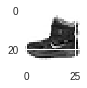

Predicted class: 9, confidence: 98.987%
Actual class: 9 




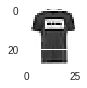

Predicted class: 2, confidence: 99.971%
Actual class: 2 




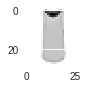

Predicted class: 1, confidence: 100.0%
Actual class: 1 




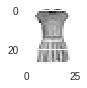

Predicted class: 1, confidence: 100.0%
Actual class: 1 




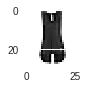

Predicted class: 6, confidence: 89.767%
Actual class: 6 




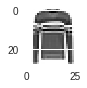

Predicted class: 1, confidence: 99.995%
Actual class: 1 




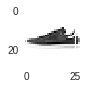

Predicted class: 4, confidence: 88.968%
Actual class: 4 




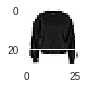

Predicted class: 6, confidence: 95.252%
Actual class: 6 




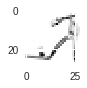

Predicted class: 5, confidence: 99.869%
Actual class: 5 




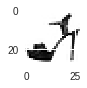

Predicted class: 7, confidence: 99.997%
Actual class: 7 




In [42]:
predictions = estimator.predict(input_fn=input_fn("predict", training=False, batch_size=1))

for i, val in enumerate(predictions):
    predicted_class = val['class_ids'][0]
    prediction_confidence = val['probabilities'][predicted_class] * 100
    
    # Display the image
    plt.imshow(x_train[i])
    plt.rcParams['figure.figsize'] = (1,1)
    plt.show()
    
    print('Predicted class: %s, confidence: %s%%' % (predicted_class, round(prediction_confidence, 3)))
    print('Actual class: %s \n\n' % y_test[i])

## Conclusion and next steps

In this tutorial, you learned how to customize `adanet` to encode your
understanding of a particular dataset, and explore novel search spaces with
AdaNet.

One use-case that has worked for us at Google, has been to take a production
model's TensorFlow code, convert it to into an `adanet.subnetwork.Builder`, and
adaptively grow it into an ensemble. In many cases, this has given significant
performance improvements.

As an exercise, you can swap out the FASHION-MNIST with the MNIST handwritten
digits dataset in this notebook using `tf.keras.datasets.mnist.load_data()`, and
see how `SimpleCNN` performs.